# Bayesian Ridge Linear Regression

In this notebook, we perform a Bayesian Ridge Linear Regression. Teh advantage of the Bayesian approach is that it calculates the ridge parameters using the data.

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, cross_val_predict, LeaveOneOut, GridSearchCV
from scripts import function

In [4]:
def summarize_coef(model, var_names):
    # Builds a pandas dataframe with the mean and standard deviation 
    # values for the intercept and features parameters. Returns a pandas Dataframe
    
    import pandas as pd
    coef=model.coef_
    cov_matrix=model.sigma_
    intercept=model.intercept_
    
    mean_array=[]
    std_array=[]
    for i,c in enumerate(coef):
        mean_array.append(c)
        std_array.append(cov_matrix[i,i])
        
    df_dict={'Mean':mean_array,'Std':std_array}
    df=pd.DataFrame(df_dict, index=var_names)
    return df

In [5]:
merged_df = pd.read_csv("Clean_data/Merged_data.csv")
merged_df.rename(columns={'Total Conversions':'Total_Conversions','Site Bin':'Sb',
                          'Placement Pixel Size Bin':'Pb'},inplace=True)

In [6]:
#not_problematic_df = merged_df[~((merged_df['Clicks']>0) & (merged_df['Impressions']==0))]
#not_problematic_df['prop']=not_problematic_df['Clicks'].div(not_problematic_df['Impressions'])

In [7]:
#not_problematic_df.groupby('Pb')['prop'].median()

In [8]:
#cond=((merged_df['Clicks']>0) & (merged_df['Impressions']==0))
#merged_df.loc[cond,'Reach']=merged_df.loc[cond,'Reach']/0.003708

Remove some outliers

In [9]:
np.max(np.log10(merged_df['Total_Conversions']+1))

5.689403878400139

In [10]:
merged_df=merged_df[np.log10(merged_df['Total_Conversions']+1)<5.0]

In [11]:
num_variables=['Reach']
#cat_variables = []
cat_variables = ['Sb', 'Pb']
formula = 'Total_Conversions ~ Reach + Reach:Sb + Reach:Pb + Reach:Sb:Pb - 1'
#formula = 'Total_Conversions ~ Reach + Reach:Sb - 1'

In [12]:
smote_cond = np.log10(merged_df['Total_Conversions']+1)>1.0

Make transformations

In [13]:
merged_df['Clicks'],clicks_mean,clicks_var = function.make_all_transform(merged_df,'Clicks',
                                                                         log=True,normalize=True)
merged_df['Impressions'],imp_mean,imp_var = function.make_all_transform(merged_df,'Impressions',
                                                                         log=True,normalize=True,
                                                                         scale=True)
merged_df['Reach'],reach_mean,reach_var = function.make_all_transform(merged_df,'Reach',
                                                                         log=True,normalize=True)

merged_df['Total_Conversions'],_,_=function.make_all_transform(merged_df,'Total_Conversions',
                                                               log=True,normalize=True)

In [14]:
#split between smote and test data
X_smote,X_test,Y_smote,Y_test = train_test_split(merged_df[num_variables + cat_variables],
                                                 merged_df[['Total_Conversions']], 
                                                 test_size = 0.2, random_state=12)
df_smote = pd.concat([X_smote,Y_smote],axis=1)

## SMOTE

In [15]:
df_smote = function.apply_smote(df_smote, smote_cond,cat_vars=cat_variables, one_hot=False)

#### Select variables

In [380]:
import patsy
Y_train,X_train_encoded = patsy.dmatrices(formula,df_smote,return_type='dataframe')

## Model

In [381]:
#X_train = merged_df[variables]
#Y_train = merged_df['Total Conversions']

#X_train_encoded=pd.get_dummies(X_train)

In [382]:
params = {'alpha_1':np.linspace(1e-6,1,10000),
          'alpha_2':np.linspace(1e-6,1,10000),
          'lambda_1':np.linspace(1e-6,1,10000),
          'lambda_2':np.linspace(1e-6,1,10000)}

reg = RandomizedSearchCV(BayesianRidge(fit_intercept=False), param_distributions=params, cv=5, random_state=123, n_iter=1000)
reg.fit(X_train_encoded,Y_train.values.flatten())

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=1000, n_jobs=None,
                   param_distributions={'alpha_1': array([1.00000000e-06, 1.01009901e-04, 2.010...
       9.99799980e-01, 9.99899990e-01, 1.00000000e+00]),
                                        'lambda_1': array([1.00000000e-06, 1.01009901e-04, 2.01019802e-04, ...,
       9.99799980e-01, 9.99899990e-01, 1.00000000e+00]),
                                        'lambda_2': array([1.00000000e-06, 1.01009901e-04, 2.01019802e-04, ...,
       9.99799980

In [383]:
reg.best_params_

{'lambda_2': 0.021703148514851486,
 'lambda_1': 0.7432745841584159,
 'alpha_2': 0.9221922970297031,
 'alpha_1': 0.4729478217821782}

In [384]:
#perform cross validation
cv=5

scoring=['neg_mean_squared_error','neg_mean_absolute_error','r2']
cv_results = cross_validate(reg.best_estimator_, X_train_encoded, Y_train.values.flatten(), cv=5, 
                            scoring=scoring)

In [385]:
cv_results

{'fit_time': array([0.01464605, 0.01072884, 0.00886703, 0.00893688, 0.00866675]),
 'score_time': array([0.00267982, 0.00248337, 0.0021379 , 0.00217915, 0.00218129]),
 'test_neg_mean_squared_error': array([-0.07239934, -0.0821168 , -0.0684589 , -0.06104123, -0.04970264]),
 'test_neg_mean_absolute_error': array([-0.16997134, -0.17883521, -0.16808742, -0.16170053, -0.15138336]),
 'test_r2': array([0.27816848, 0.34804224, 0.4098352 , 0.29909119, 0.24515272])}

In [386]:
print("RMSE = {:.3f}".format(np.mean(np.sqrt(-1*cv_results['test_neg_mean_squared_error']))))
print("R2 = {:.3f}".format(np.mean(cv_results['test_r2'])))

RMSE = 0.257
R2 = 0.316


### Residual

In [387]:
y_pred = cross_val_predict(reg.best_estimator_, X_train_encoded, Y_train.values.flatten(), cv=cv)
y_true = Y_train.values.flatten()
resid = (10**y_true-1) - (10**y_pred-1)

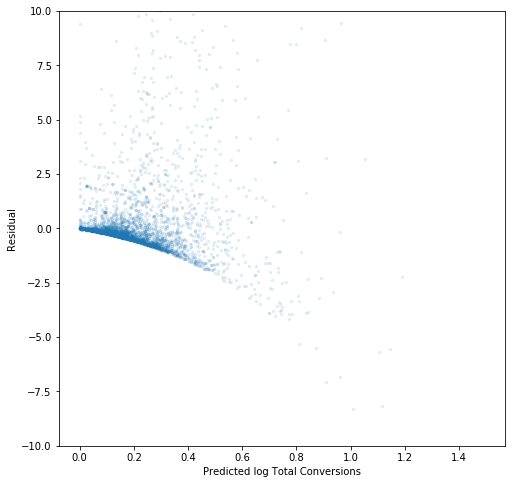

In [388]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(y_pred,resid,s=5, alpha=0.1)
plt.xlabel('Predicted log Total Conversions')
plt.ylabel ('Residual')
plt.ylim(-10,10)
plt.show()

(0, 1)

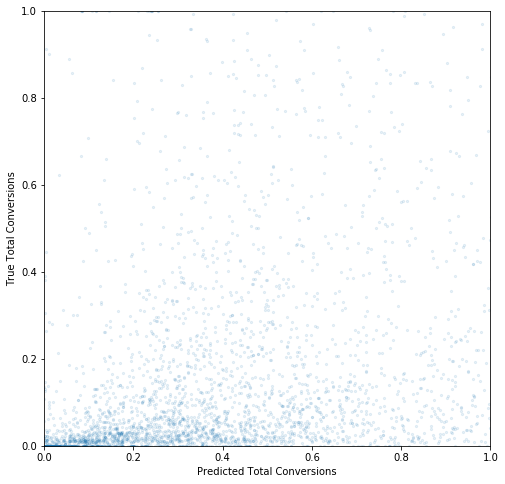

In [389]:
plt.figure(figsize=(8,8))
plt.scatter(10**y_pred-1,10**y_true-1,s=5, alpha=0.1)
plt.xlabel('Predicted Total Conversions')
plt.ylabel ('True Total Conversions')
plt.xlim(0,1)
plt.ylim(0,1)

## Metrics with test set

In [390]:
#df_test = pd.concat([X_test,Y_test], axis=1)
#y_test,X_test_encoded = patsy.dmatrices(formula,df_test,return_type='dataframe')

In [391]:
#X_test_encoded = function.fix_encoded_test(X_train_encoded, X_test_encoded)
build_encoding = X_train_encoded.design_info

In [392]:
X_test_encoded, = patsy.build_design_matrices([build_encoding], X_test, return_type='dataframe')

y_pred = reg.predict(X_test_encoded)

In [393]:
y_pred

array([0.33455378, 0.01871999, 0.26078382, ..., 0.10221145, 0.0264172 ,
       0.00177844])

In [394]:
y_true = Y_test.values.flatten()

r2=r2_score(y_true,y_pred)
print("RMSE = {:.3f}".format(np.sqrt(mean_squared_error(y_true,y_pred))))
print("Median Absolute Error = {:.3f}".format(median_absolute_error(y_true,y_pred)))
print("Mean Absolute Error = {:.3f}".format(mean_absolute_error(y_true,y_pred)))
print("R2 = {:.3f}".format(r2))

def adjusted_r2(r2,n_vars,n):
    
    return 1-((1-r2)*(n-1)/(n-n_vars-1))

n_vars = len(num_variables)+len(cat_variables)
print("Adjusted R2 = {:.3f}".format(adjusted_r2(r2,n_vars,len(X_test))))

RMSE = 0.259
Median Absolute Error = 0.111
Mean Absolute Error = 0.166
R2 = 0.387
Adjusted R2 = 0.385


In [395]:
def mape(y_true,y_pred):
    
    y_true=10**y_true-1
    y_pred=10**y_pred-1
    
    dif=abs((y_true - y_pred)/y_true)
    dif = np.mean(dif[dif!=np.inf])*100
    
    return dif

def smape(y_true,y_pred):
    y_true=10**y_true-1
    y_pred=10**y_pred-1
    
    num=abs(y_pred-y_true)
    denom=(abs(y_true)+abs(y_pred))*0.5
    
    p=np.mean(num/denom)*100
    
    return p

print("MAPE = {:.3f}".format(mape(y_true,y_pred)))
print("SMAPE = {:3f}".format(smape(y_true,y_pred)))

MAPE = 637.072
SMAPE = 121.511462


/Users/smarchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


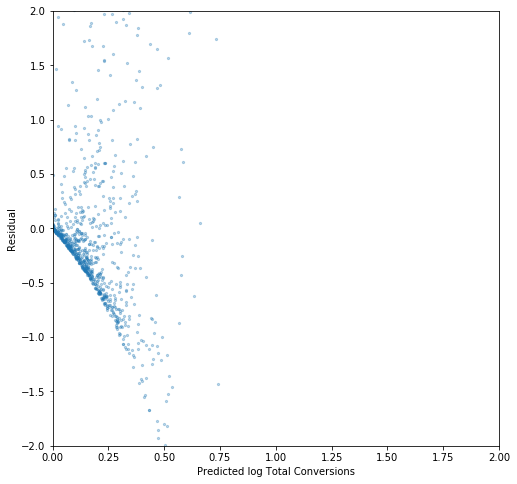

In [396]:
resid = (10**y_true-1) - (10**y_pred-1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(y_pred,resid,s=5, alpha=0.3)
plt.xlabel('Predicted log Total Conversions')
plt.ylabel ('Residual')
plt.ylim(-2,2)
plt.xlim(0,2)
plt.show()

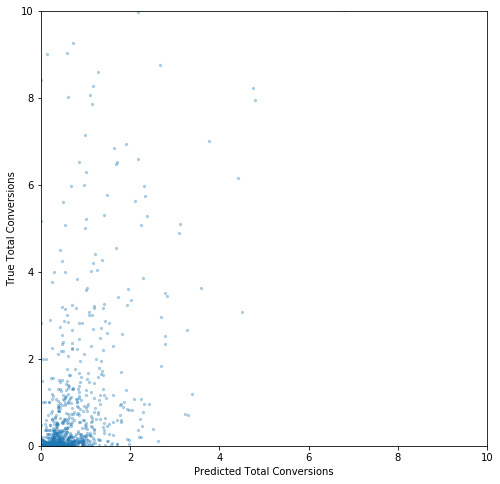

In [397]:
plt.figure(figsize=(8,8))
plt.scatter(10**y_pred-1,10**y_true-1,s=5, alpha=0.3)
plt.xlabel('Predicted Total Conversions')
plt.ylabel ('True Total Conversions')
plt.ylim(0,10)
plt.xlim(0,10)
plt.show()

In [398]:
coef_df = summarize_coef(reg.best_estimator_, X_train_encoded.columns)

In [399]:
#Save model and coef table
#import pickle
#dict_to_pickle = {'model':reg.best_estimator_, 'formula':formula, 'train_data':df_smote}
#pickle.dump(dict_to_pickle, open( "models/ReachSbPb.p", "wb" ))

#coef_df.to_csv("models/ReachSbPb_coef.csv")

In [400]:
#predict test
reach=np.log10(np.array([3.0])+1)
site=['Facebook']
ad_type=['Banner']

predict_df =pd.DataFrame({'Reach':reach, 'Sb':site, 'Pb':ad_type})
predict_df, = patsy.build_design_matrices([build_encoding], predict_df, return_type='dataframe')

In [401]:
10**reg.best_estimator_.predict(predict_df)-1

array([0.05388672])